In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
from lib.loads import parse_loads, convert_offline_to_online_input, select_load_from_nth_last_day, perfect_load_prediction, predict_loads
from lib.model import build_model, FACEBOOK_2009_0, FACEBOOK_2009_1, FACEBOOK_2010, LANL_MUSTANG, MICROSOFT_FIDDLE, ALIBABA, ENERGY_MODEL_WIERMAN, ENERGY_MODEL_ALTERNATIVE
from lib.utils import summarize_distribution, plot_cdf, plot

In [13]:
# import logging

# FORMAT = '%(levelname)s %(name)s %(asctime)-15s %(filename)s:%(lineno)d %(message)s'
# logging.basicConfig(format=FORMAT)
# logging.getLogger().setLevel(logging.DEBUG)

In [14]:
TIME_SLOT_LENGTH = 60 * 60
NORMALIZED_SWITCHING_COST = 4
REVENUE_LOSS = 0.1

In [15]:
TRACE = ALIBABA

# Model

In [16]:
model = build_model(
  TRACE,
  ENERGY_MODEL_ALTERNATIVE,
  TIME_SLOT_LENGTH,
  NORMALIZED_SWITCHING_COST,
  REVENUE_LOSS,
)

# Inputs

In [17]:
offline_input = select_load_from_nth_last_day(parse_loads(TRACE), TIME_SLOT_LENGTH, 2)
# perfect_knowledge_online_input = perfect_load_prediction(offline_input)
perfect_knowledge_online_input = predict_loads(TRACE, offline_input)

-48 -25


In [18]:
# [np.array(x, dtype=object).shape for x in perfect_knowledge_online_input]

In [19]:
# offline_input = np.array(offline_input).sum(axis=1)
# print(offline_input.shape)
# np.array(offline_input).max() / np.array(offline_input).mean()

In [20]:
# loads = np.array(offline_input)
# valley_lengths = np.array([i - (np.argwhere(loads[:i] >= loads[i]).max(initial=-1)) - 1 for i in range(loads.shape[0])])
# summarize_distribution(valley_lengths)

# Execute

## Offline

In [21]:
from lib.offline import evaluate_1d

opt, iopt, runtime_opt, runtime_iopt = evaluate_1d(model, [offline_input[19], offline_input[20], offline_input[21], offline_input[22], offline_input[23]])

[[4704], [5989], [5989], [5989], [5989]] 10049663.962971285


In [22]:
opt, iopt

(1, 34703599.980553135)

In [ ]:
from lib.offline import evaluate_static

opts, iopts, runtime_opts, runtime_iopts = evaluate_static(model, offline_input)

In [ ]:
opts, iopts

(1, 35085715.86748265)

### Fractional vs Integral

In [ ]:
opt_vs_iopt = iopt / opt
opts_vs_iopts = iopts / opts
opt_vs_iopt, opts_vs_iopts

(93800482.54993325, 98296460.62086403)

### Opt vs OptS

In [ ]:
opt_vs_opts = opts / opt
iopt_vs_iopts = iopts / iopt
opt_vs_opts, iopt_vs_iopts

(1.0, 1.0479312893570394)

### Runtimes

In [ ]:
runtime_opt, runtime_iopt, runtime_opts, runtime_iopts

(0, 428, 0, 602)

### Approximation algorithm

In [ ]:
gammas = np.logspace(
  0.2, 3, 8, base=2
)
gammas

array([1.14869835, 1.51571657, 2.        , 2.63901582, 3.48220225,
       4.59479342, 6.06286627, 8.        ])

In [ ]:
from lib.offline import evaluate_approx_graph_search

x, y, approx_opt_runtimes = evaluate_approx_graph_search(model, offline_input, gammas)

In [ ]:
# plt.axhline(y=iopt, color='r', linestyle='-')
plot(x, np.array(y) / iopt, 'gamma', 'normalized cost', 'approx_graph_search')
plt.show()

In [ ]:
plot(x, approx_opt_runtimes, 'gamma', 'runtime (milliseconds)', 'approx_graph_search_runtime')
plt.show()

## Online

In [39]:
from lib.online import evaluate_receding_horizon_control

initial_alg, alg, initial_ialg, ialg, energy_cost, revenue_loss, switching_cost, initial_runtime, runtimes, memory = evaluate_receding_horizon_control(model, [], perfect_knowledge_online_input, 0)

100%|██████████| 24/24 [00:00<00:00, 47.31it/s]

Resulting schedule: [[3829], [3829], [3829], [3829], [3829], [3829], [5768], [5770], [5839], [5839], [5840], [5840], [5840], [5840], [5840], [5840], [5840], [5840], [5840], [5840], [5840], [5840], [5840], [5840]]


In [40]:
alg, ialg, energy_cost, revenue_loss, switching_cost, memory[len(memory) - 1]

(36228356.70842583,
 36226269.16163537,
 22358274.527091946,
 11021345.034543425,
 2846649.5999999978,
 None)

## Evaluation

### Competitive Ratio

In [24]:
cr = alg / opt
icr = ialg / iopt
cr, icr

(34265089.44664767, 1.0175719045646099)

### Competitive Difference

In [25]:
cd = alg - opt
icd = ialg - iopt
cd, icd

(34265088.44664767, 591705.4892665669)

### Regret

In [26]:
regret = alg - opts
iregret = ialg - iopts
regret, iregret

(34265088.44664767, -582239.9193292111)

### Cost Change

Regret relative to overall cost.

In [27]:
rel_regret = regret / opts
rel_iregret = iregret / iopts
rel_regret, rel_iregret

(34265088.44664767, -0.0167083082096294)

Competitive difference relative to overall cost.

In [364]:
rel_cd = cd / opt
rel_icd = icd / iopt
rel_cd, rel_icd

(2124460.1202756837, 0.08824518144969559)

### Fractional vs Integral

In [ ]:
alg_vs_ialg = ialg / alg
alg_vs_ialg

1.0

### Runtime

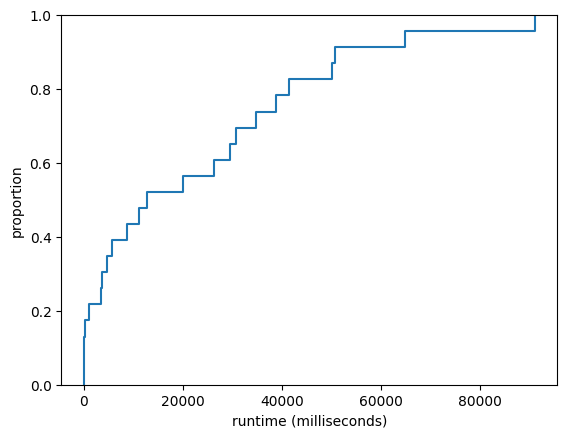

DistributionSummary(mean=23019.695652173912, median=12757.0, modes=array([3]), std=23916.79917771967, mad=12752.0, min_=3, p25=3578.5, p75=36736.0, max_=91032)

In [31]:
runtimes_np = np.array(runtimes)
plot_cdf(runtimes_np, 'runtime (milliseconds)', 'online_runtime')
plt.show()
summarize_distribution(runtimes_np)

### Model

Proportion of energy cost to delay cost

In [ ]:
ec_vs_rl = energy_cost / revenue_loss if revenue_loss > 0 else np.Inf
hc_vs_sc = (energy_cost + revenue_loss) / switching_cost
ec_vs_rl, hc_vs_sc

(4.928890525519765, 1841.2474518509073)